# IIT 4316 Deep Learning<br>Homework #2-2: Transformer

# 1. Define.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import math
from tqdm import tqdm as tq

DIGITS     = ['0','1','2','3','4','5','6','7','8','9']
VOCAB_SIZE = len(DIGITS)
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

# Fixed hyperparameters
INPUT_LEN     = 4
OUTPUT_LEN    = 3
LEARNING_RATE = 1e-4
NUM_EPOCH     = 1000
BATCH_SIZE    = 128

# Changable hyperparameters
EMBED_DIM         = 4096
ENCODER_LAYER_NUM = 2
HIDDEN_DIM        = 64

char_to_idx = {c:i for i,c in enumerate(DIGITS)}
idx_to_char = {i:c for i,c in enumerate(DIGITS)}

# batch data generation
def generate_batch(batch_size=100):
    inputs, targets = [], []
    for _ in range(batch_size):
        tens1, ones1 = random.randint(0, 9), random.randint(0, 9)
        tens2, ones2 = random.randint(0, 9), random.randint(0, 9)
        num1, num2 = tens1 * 10 + ones1, tens2 * 10 + ones2
        s = num1 + num2
        inputs.append([tens1, ones1, tens2, ones2])
        sum_str = f"{s:03d}"
        targets.append([char_to_idx[c] for c in sum_str])
    return (torch.tensor(inputs, dtype=torch.long).to(DEVICE),
            torch.tensor(targets, dtype=torch.long).to(DEVICE))

# ReLU
def my_relu(x):
    return torch.clamp(x, min=0.0)

#------------------------------------
# Layer Normalization (for stability with large dimensions)
#------------------------------------
class MyLayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta  = nn.Parameter(torch.zeros(dim))
        self.eps   = eps
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std  = x.std(dim=-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

#------------------------------------
# 4 digits to one-hot vectors
#------------------------------------
def MyOneHot(x, vocab_size):    
    B, L = x.size()     # batch size x INPUT_LEN

    ############################################################################
    # TODO: Convert x to one-hot
    ############################################################################

    # Create zero tensor of shape (B, L, vocab_size)
    out = torch.zeros(B, L, vocab_size, device=x.device)
    # Use scatter to fill in the one-hot encoding
    out.scatter_(2, x.unsqueeze(2), 1.0)

    ############################################################################
    # END TODO
    ############################################################################

    return out   # B x L x vocab_size

#------------------------------------
# Embedding layer
#------------------------------------
class MyEmbedding(nn.Module):
    def __init__(self, vocab_size, dim):
        super().__init__()
        # Xavier initialization for stability
        self.weight = nn.Parameter(torch.randn(vocab_size, dim) * math.sqrt(2.0 / (vocab_size + dim)))

    def forward(self, x):
        B, L = x.size()

        ############################################################################
        # TODO: Convert x to one-hot and then embedding
        #    Use MyOneHot() function above.
        ############################################################################

        # Convert to one-hot: (B, L, vocab_size)
        one_hot = MyOneHot(x, self.weight.size(0))
        # Matrix multiply with embedding weight: (B, L, vocab_size) @ (vocab_size, dim) = (B, L, dim)
        out = torch.matmul(one_hot, self.weight)
        
        ############################################################################
        # END TODO
        ############################################################################

        return out  # B x L x dim

#------------------------------------
# Linear layer
#------------------------------------
class MyLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        # Xavier initialization for stability
        self.weight = nn.Parameter(torch.randn(out_dim, in_dim) * math.sqrt(2.0 / (in_dim + out_dim)))
        self.bias   = nn.Parameter(torch.zeros(out_dim))

    def forward(self, x):

        ############################################################################
        # TODO: Compute linear layer output
        #   You should implement your own linear layer operation.
        ############################################################################
            
        # x: (..., in_dim), weight: (out_dim, in_dim), bias: (out_dim)
        # out = x @ W^T + bias
        out = torch.matmul(x, self.weight.t()) + self.bias
        
        ############################################################################
        # END TODO
        ############################################################################

        return out  

#------------------------------------
# Self-attention operation
#------------------------------------
class MySelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()

        ############################################################################
        # TODO: Define operations to obtain query, key, value from x.
        #   Use MyLinear class defined above.
        ############################################################################

        self.embed_dim = embed_dim
        self.query     = MyLinear(embed_dim, embed_dim)
        self.key       = MyLinear(embed_dim, embed_dim)
        self.value     = MyLinear(embed_dim, embed_dim)

        ############################################################################
        # END TODO
        ############################################################################

    def forward(self, x):

        ############################################################################
        # TODO: Scaled dot-product attention
        #  You should implement your own self-attention operation.
        #  You can use F.softmax for softmax operation and math.sqrt for square root operation.
        ############################################################################

        # x: (B, L, embed_dim)
        Q = self.query(x)  # (B, L, embed_dim)
        K = self.key(x)    # (B, L, embed_dim)
        V = self.value(x)  # (B, L, embed_dim)
        
        # Scaled dot-product attention
        # scores = Q @ K^T / sqrt(d_k)
        d_k    = self.embed_dim
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)  # (B, L, L)
        
        # Softmax over the last dimension
        attn_weights = F.softmax(scores, dim=-1)  # (B, L, L)
        
        # Apply attention to values
        attn_output = torch.matmul(attn_weights, V)  # (B, L, embed_dim)
        
        # Skip connection
        out = attn_output + x
        
        ############################################################################
        # END TODO
        ############################################################################

        return out

#------------------------------------
# Encoder layer
#------------------------------------
class MyEncoderLayer(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()

        ############################################################################
        # TODO: Define each sub-layer (self-attention, linear1, linear2)
        #   Use MyLinear class defined above.
        ############################################################################

        self.self_attention = MySelfAttention(embed_dim)
        # 2-layer MLP: embed_dim -> hidden_dim -> embed_dim
        self.linear1 = MyLinear(embed_dim, hidden_dim)
        self.linear2 = MyLinear(hidden_dim, embed_dim)
        
        # Layer Normalization for stability
        self.norm1 = MyLayerNorm(embed_dim)
        self.norm2 = MyLayerNorm(embed_dim)
        
        ############################################################################
        # END TODO
        ############################################################################

    def forward(self, x):

        ############################################################################
        # TODO: Define forward path:  
        #    self-attention (with skip) -> 2-layer MLP (with skip)
        ############################################################################

        # Self-attention with skip connection (already included in MySelfAttention)
        x = self.self_attention(x)  # (B, L, embed_dim)
        x = self.norm1(x)           # Layer Normalization
        
        # 2-layer MLP with skip connection
        mlp_out = self.linear1(x)       # (B, L, hidden_dim)
        mlp_out = my_relu(mlp_out)      # ReLU activation
        mlp_out = self.linear2(mlp_out) # (B, L, embed_dim)
        
        # Skip connection for MLP
        out = mlp_out + x
        out = self.norm2(out)           # Layer Normalization

        ############################################################################
        # END TODO
        ############################################################################
        
        return out     

# --------------------
# Transformer model
# --------------------
class MyTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_encoder_layers):
        super().__init__()
        
        ############################################################################
        # TODO: Define each layer (embedding, enc1, enc2, ..., fc).
        #   Use MyEmbedding, MyEncoderLayer, MyLinear classes defined above.
        ############################################################################

        self.embed_dim          = embed_dim
        self.num_encoder_layers = num_encoder_layers
        
        # Embedding layer
        self.embedding = MyEmbedding(vocab_size, embed_dim)
        
        # Encoder layers using nn.ModuleList for dynamic number of layers
        self.encoder_layers = nn.ModuleList()
        for _ in range(num_encoder_layers):
            self.encoder_layers.append(MyEncoderLayer(embed_dim, hidden_dim))
        
        # FC layer: input is flattened encoder output (INPUT_LEN * embed_dim), output is OUTPUT_LEN * VOCAB_SIZE
        self.fc = MyLinear(INPUT_LEN * embed_dim, OUTPUT_LEN * vocab_size)

        ############################################################################
        # END TODO
        ############################################################################

    def forward(self, x):

        ############################################################################
        # TODO: Define forward path 
        #   embedding -> encoder layer 1 -> encoder layer 2 -> ... -> flatten -> linear layer
        ############################################################################

        B = x.size(0)
        
        # Embedding: (B, 4) -> (B, 4, embed_dim)
        out = self.embedding(x)
        
        # Apply encoder layers
        for encoder in self.encoder_layers:
            out = encoder(out)  # (B, 4, embed_dim)
        
        # Flatten: (B, 4, embed_dim) -> (B, 4 * embed_dim)
        out = out.view(B, -1)
        
        # FC layer: (B, 4 * embed_dim) -> (B, 3 * VOCAB_SIZE)
        out = self.fc(out)
        
        # Reshape to (B, 3, VOCAB_SIZE)
        out = out.view(B, OUTPUT_LEN, VOCAB_SIZE)

        ############################################################################
        # END TODO
        ############################################################################

        return out    # B x 3 x VOCAB_SIZE


# 2. Run.

In [2]:
# --------------------
# Training & test
# --------------------
def main():
    torch.manual_seed(42)
    random.seed(42)

    model     = MyTransformer(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, ENCODER_LAYER_NUM).to(DEVICE)
    optim     = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    for epoch in tq(range(1, NUM_EPOCH+1)):
        model.train()
        src, tgt = generate_batch(BATCH_SIZE)
        logits   = model(src)
        loss     = criterion(logits.view(-1, VOCAB_SIZE), tgt.view(-1))

        optim.zero_grad()
        loss.backward()
        
        # Gradient Clipping to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optim.step()

        if epoch % 100 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d}  Loss: {loss.item():.4f}")

    # Evaluation
    model.eval()
    correct = 0
    total   = 0
    with torch.no_grad():
        src, tgt = generate_batch(1000)
        logits   = model(src)
        preds    = logits.argmax(-1)
        for s, t, p in zip(src.cpu().tolist(), tgt.cpu().tolist(), preds.cpu().tolist()):
            s_str = f"{s[0]}{s[1]} + {s[2]}{s[3]}"
            t_str = ''.join(idx_to_char[x] for x in t)
            p_str = ''.join(idx_to_char[x] for x in p)
            print(f"src: {s_str} = {t_str} | pred: {p_str}")
            if t_str == p_str:
                correct += 1
            total += 1
    print(f"Correct: {correct}/{total}")

if __name__ == "__main__":
    main()

  0%|          | 3/1000 [00:02<10:23,  1.60it/s]

Epoch 001  Loss: 2.6582


 10%|█         | 100/1000 [00:22<04:04,  3.68it/s]

Epoch 100  Loss: 1.4751


 20%|██        | 200/1000 [00:42<03:42,  3.59it/s]

Epoch 200  Loss: 1.2476


 30%|███       | 300/1000 [01:03<03:07,  3.73it/s]

Epoch 300  Loss: 1.0392


 40%|████      | 400/1000 [01:24<02:32,  3.92it/s]

Epoch 400  Loss: 0.7093


 50%|█████     | 500/1000 [01:45<02:05,  3.99it/s]

Epoch 500  Loss: 0.4743


 60%|██████    | 600/1000 [02:05<01:40,  3.98it/s]

Epoch 600  Loss: 0.4140


 70%|███████   | 700/1000 [02:26<01:15,  3.99it/s]

Epoch 700  Loss: 0.3389


 80%|████████  | 800/1000 [02:46<00:49,  4.02it/s]

Epoch 800  Loss: 0.2850


 90%|█████████ | 900/1000 [03:07<00:24,  4.00it/s]

Epoch 900  Loss: 0.2272


100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]

Epoch 1000  Loss: 0.1658


src: 93 + 63 = 156 | pred: 156
src: 92 + 52 = 144 | pred: 114
src: 17 + 89 = 106 | pred: 106
src: 72 + 31 = 103 | pred: 103
src: 43 + 66 = 109 | pred: 109
src: 19 + 56 = 075 | pred: 075
src: 12 + 99 = 111 | pred: 111
src: 66 + 87 = 153 | pred: 153
src: 24 + 67 = 091 | pred: 091
src: 87 + 27 = 114 | pred: 114
src: 97 + 76 = 173 | pred: 173
src: 03 + 18 = 021 | pred: 031
src: 14 + 04 = 018 | pred: 018
src: 77 + 16 = 093 | pred: 093
src: 46 + 01 = 047 | pred: 047
src: 22 + 10 = 032 | pred: 032
src: 85 + 14 = 099 | pred: 099
src: 19 + 73 = 092 | pred: 092
src: 99 + 18 = 117 | pred: 117
src: 42 + 11 = 053 | pred: 053
src: 05 + 47 = 052 | pred: 042
src: 36 + 94 = 130 | pred: 130
src: 39 + 42 = 081 | pred: 081
src: 90 + 19 = 109 | pred: 109
src: 56 + 37 = 093 | pred: 093
src: 14 + 06 = 020 | pred: 020
src: 60 + 63 = 123 | pred: 123
src: 72 + 66 = 138 | pred: 138
src: 75 + 07 = 082 | pred: 082
src: 36 + 19 = 055 | pred: 005
src: 33 + 59 = 092 | pred: 092
src: 70 + 31 = 101 | pred: 101
src: 97 

# 3. Plotting.

## 3.1. Hyperparameter Experiments

In [3]:
import matplotlib.pyplot as plt
import time

# ============================================================
# Hyperparameter Experiment for Transformer
# ============================================================

def train_and_evaluate(vocab_size, embed_dim, hidden_dim, num_encoder_layers, 
                       num_epochs=1000, batch_size=128, lr=1e-4, test_size=1000):
    """Train model and return final loss, test accuracy, and training time."""
    torch.manual_seed(42)
    random.seed(42)
    
    model     = MyTransformer(vocab_size, embed_dim, hidden_dim, num_encoder_layers).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Training with time measurement
    start_time = time.time()
    final_loss = 0
    for epoch in range(1, num_epochs + 1):
        model.train()
        src, tgt = generate_batch(batch_size)
        logits   = model(src)
        loss     = criterion(logits.view(-1, VOCAB_SIZE), tgt.view(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        final_loss = loss.item()
    train_time = time.time() - start_time
    
    # Evaluation
    model.eval()
    correct = 0
    with torch.no_grad():
        src, tgt = generate_batch(test_size)
        logits   = model(src)
        preds    = logits.argmax(-1)
        for t, p in zip(tgt.cpu().tolist(), preds.cpu().tolist()):
            if t == p:
                correct += 1
    
    return final_loss, correct, train_time

# Default values
DEFAULT_EMBED_DIM         = 32
DEFAULT_ENCODER_LAYER_NUM = 2
DEFAULT_HIDDEN_DIM        = 64

# ============================================================
# Experiment 1: Varying EMBED_DIM
# ============================================================
print("=" * 50)
print("Experiment 1: Varying EMBED_DIM")
print("=" * 50)

embed_dims   = [64, 128, 256, 512, 1024, 2048, 4096, 8192]
losses_embed = []
accs_embed   = []
times_embed  = []

for ed in tq(embed_dims, desc="EMBED_DIM"):
    loss, acc, t = train_and_evaluate(VOCAB_SIZE, ed, DEFAULT_HIDDEN_DIM, DEFAULT_ENCODER_LAYER_NUM)
    losses_embed.append(loss)
    accs_embed.append(acc)
    times_embed.append(t)
    print(f"EMBED_DIM={ed:3d} | Loss: {loss:.4f} | Correct: {acc}/1000 | Time: {t:.2f}s")

# ============================================================
# Experiment 2: Varying ENCODER_LAYER_NUM
# ============================================================
print("\n" + "=" * 50)
print("Experiment 2: Varying ENCODER_LAYER_NUM")
print("=" * 50)

encoder_layers = [1, 2, 3, 4, 5, 6, 7, 8]
losses_encoder = []
accs_encoder   = []
times_encoder  = []

for nl in tq(encoder_layers, desc="ENCODER_LAYER_NUM"):
    loss, acc, t = train_and_evaluate(VOCAB_SIZE, DEFAULT_EMBED_DIM, DEFAULT_HIDDEN_DIM, nl)
    losses_encoder.append(loss)
    accs_encoder.append(acc)
    times_encoder.append(t)
    print(f"ENCODER_LAYER_NUM={nl} | Loss: {loss:.4f} | Correct: {acc}/1000 | Time: {t:.2f}s")

# ============================================================
# Experiment 3: Varying HIDDEN_DIM
# ============================================================
print("\n" + "=" * 50)
print("Experiment 3: Varying HIDDEN_DIM")
print("=" * 50)

hidden_dims   = [16, 32, 48, 64, 96, 128, 192, 256]
losses_hidden = []
accs_hidden   = []
times_hidden  = []

for hd in tq(hidden_dims, desc="HIDDEN_DIM"):
    loss, acc, t = train_and_evaluate(VOCAB_SIZE, DEFAULT_EMBED_DIM, hd, DEFAULT_ENCODER_LAYER_NUM)
    losses_hidden.append(loss)
    accs_hidden.append(acc)
    times_hidden.append(t)
    print(f"HIDDEN_DIM={hd:3d} | Loss: {loss:.4f} | Correct: {acc}/1000 | Time: {t:.2f}s")

Experiment 1: Varying EMBED_DIM


EMBED_DIM:  12%|█▎        | 1/8 [00:06<00:48,  6.98s/it]

EMBED_DIM= 64 | Loss: 1.4192 | Correct: 64/1000 | Time: 6.95s


EMBED_DIM:  25%|██▌       | 2/8 [00:14<00:42,  7.12s/it]

EMBED_DIM=128 | Loss: 1.0690 | Correct: 246/1000 | Time: 7.17s


EMBED_DIM:  38%|███▊      | 3/8 [00:21<00:36,  7.33s/it]

EMBED_DIM=256 | Loss: 0.6745 | Correct: 440/1000 | Time: 7.51s


EMBED_DIM:  50%|█████     | 4/8 [00:31<00:32,  8.14s/it]

EMBED_DIM=512 | Loss: 0.4054 | Correct: 653/1000 | Time: 9.33s


EMBED_DIM:  62%|██████▎   | 5/8 [00:51<00:37, 12.53s/it]

EMBED_DIM=1024 | Loss: 0.2807 | Correct: 806/1000 | Time: 20.19s


EMBED_DIM:  75%|███████▌  | 6/8 [01:46<00:53, 26.89s/it]

EMBED_DIM=2048 | Loss: 0.2173 | Correct: 824/1000 | Time: 54.43s


EMBED_DIM:  88%|████████▊ | 7/8 [04:44<01:16, 76.38s/it]

EMBED_DIM=4096 | Loss: 0.1372 | Correct: 855/1000 | Time: 177.02s


EMBED_DIM: 100%|██████████| 8/8 [16:50<00:00, 126.35s/it]


EMBED_DIM=8192 | Loss: 0.4702 | Correct: 553/1000 | Time: 719.58s

Experiment 2: Varying ENCODER_LAYER_NUM


ENCODER_LAYER_NUM:  12%|█▎        | 1/8 [00:05<00:35,  5.01s/it]

ENCODER_LAYER_NUM=1 | Loss: 1.6447 | Correct: 15/1000 | Time: 4.94s


ENCODER_LAYER_NUM:  25%|██▌       | 2/8 [00:10<00:32,  5.39s/it]

ENCODER_LAYER_NUM=2 | Loss: 1.5948 | Correct: 14/1000 | Time: 5.64s


ENCODER_LAYER_NUM:  38%|███▊      | 3/8 [00:18<00:31,  6.35s/it]

ENCODER_LAYER_NUM=3 | Loss: 1.5232 | Correct: 31/1000 | Time: 7.49s


ENCODER_LAYER_NUM:  50%|█████     | 4/8 [00:27<00:30,  7.51s/it]

ENCODER_LAYER_NUM=4 | Loss: 1.4952 | Correct: 64/1000 | Time: 9.26s


ENCODER_LAYER_NUM:  62%|██████▎   | 5/8 [00:38<00:26,  8.79s/it]

ENCODER_LAYER_NUM=5 | Loss: 1.4463 | Correct: 46/1000 | Time: 11.04s


ENCODER_LAYER_NUM:  75%|███████▌  | 6/8 [00:51<00:20, 10.37s/it]

ENCODER_LAYER_NUM=6 | Loss: 1.4483 | Correct: 65/1000 | Time: 13.42s


ENCODER_LAYER_NUM:  88%|████████▊ | 7/8 [01:06<00:11, 11.88s/it]

ENCODER_LAYER_NUM=7 | Loss: 1.4420 | Correct: 59/1000 | Time: 14.96s


ENCODER_LAYER_NUM: 100%|██████████| 8/8 [01:23<00:00, 10.48s/it]


ENCODER_LAYER_NUM=8 | Loss: 1.3881 | Correct: 76/1000 | Time: 16.86s

Experiment 3: Varying HIDDEN_DIM


HIDDEN_DIM:  12%|█▎        | 1/8 [00:05<00:41,  5.86s/it]

HIDDEN_DIM= 16 | Loss: 1.6118 | Correct: 8/1000 | Time: 5.84s


HIDDEN_DIM:  25%|██▌       | 2/8 [00:11<00:35,  5.85s/it]

HIDDEN_DIM= 32 | Loss: 1.6470 | Correct: 17/1000 | Time: 5.84s


HIDDEN_DIM:  38%|███▊      | 3/8 [00:17<00:29,  5.87s/it]

HIDDEN_DIM= 48 | Loss: 1.6063 | Correct: 21/1000 | Time: 5.83s


HIDDEN_DIM:  50%|█████     | 4/8 [00:23<00:23,  5.84s/it]

HIDDEN_DIM= 64 | Loss: 1.5948 | Correct: 14/1000 | Time: 5.79s


HIDDEN_DIM:  62%|██████▎   | 5/8 [00:30<00:18,  6.29s/it]

HIDDEN_DIM= 96 | Loss: 1.5794 | Correct: 31/1000 | Time: 5.88s


HIDDEN_DIM:  75%|███████▌  | 6/8 [00:36<00:12,  6.22s/it]

HIDDEN_DIM=128 | Loss: 1.5993 | Correct: 24/1000 | Time: 5.85s


HIDDEN_DIM:  88%|████████▊ | 7/8 [00:42<00:06,  6.11s/it]

HIDDEN_DIM=192 | Loss: 1.5379 | Correct: 30/1000 | Time: 5.83s


HIDDEN_DIM: 100%|██████████| 8/8 [00:48<00:00,  6.06s/it]

HIDDEN_DIM=256 | Loss: 1.4951 | Correct: 40/1000 | Time: 5.96s


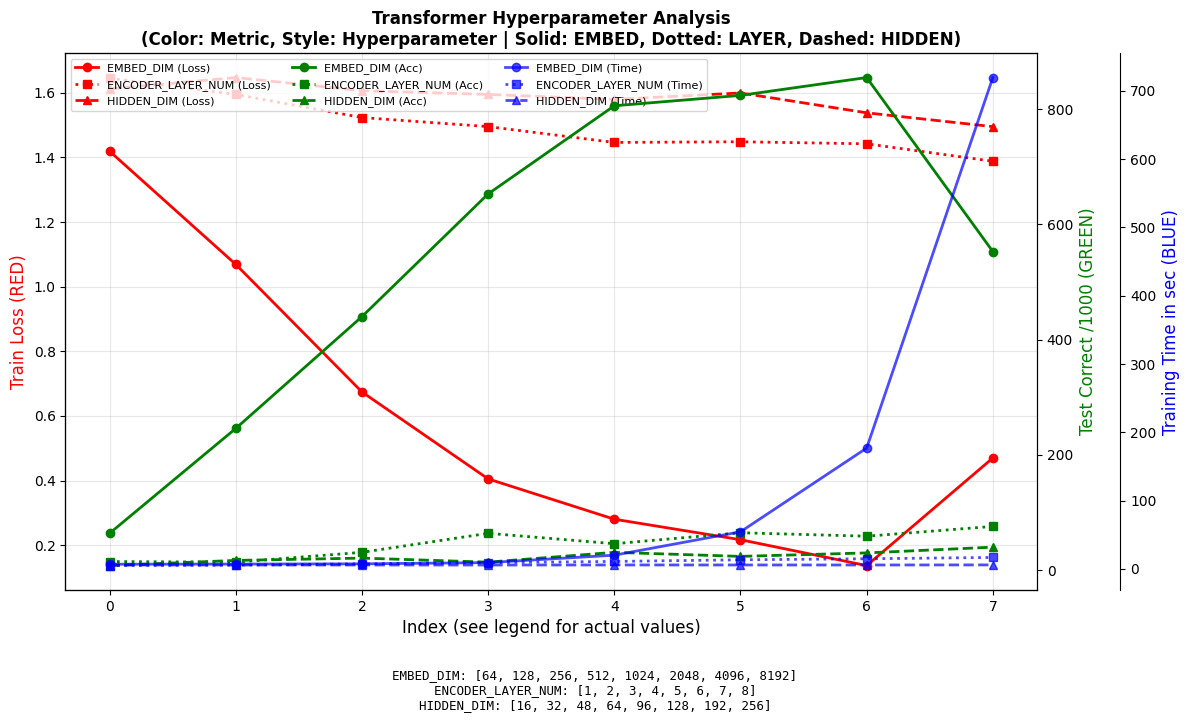

In [4]:
# ============================================================
# Plotting - Single Figure with 3 y-axes
# ============================================================
fig, ax1 = plt.subplots(figsize=(12, 7))

# Create additional y-axes
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))

# X-axis: use indices (0 to n-1)
n = len(embed_dims)
x_indices = list(range(n))

# Plot Train Loss (RED) - Left y-axis
# Solid: EMBED_DIM, Dotted: ENCODER_LAYER_NUM, Dashed: HIDDEN_DIM
l1 = ax1.plot(x_indices, losses_embed, 'r-o', linewidth=2, markersize=6, label='EMBED_DIM (Loss)')
l2 = ax1.plot(x_indices, losses_encoder, 'r:s', linewidth=2, markersize=6, label='ENCODER_LAYER_NUM (Loss)')
l3 = ax1.plot(x_indices, losses_hidden, 'r--^', linewidth=2, markersize=6, label='HIDDEN_DIM (Loss)')

# Plot Test Accuracy (GREEN) - Right y-axis 1
l4 = ax2.plot(x_indices, accs_embed, 'g-o', linewidth=2, markersize=6, label='EMBED_DIM (Acc)')
l5 = ax2.plot(x_indices, accs_encoder, 'g:s', linewidth=2, markersize=6, label='ENCODER_LAYER_NUM (Acc)')
l6 = ax2.plot(x_indices, accs_hidden, 'g--^', linewidth=2, markersize=6, label='HIDDEN_DIM (Acc)')

# Plot Training Time (BLUE) - Right y-axis 2
l7 = ax3.plot(x_indices, times_embed, 'b-o', linewidth=2, markersize=6, alpha=0.7, label='EMBED_DIM (Time)')
l8 = ax3.plot(x_indices, times_encoder, 'b:s', linewidth=2, markersize=6, alpha=0.7, label='ENCODER_LAYER_NUM (Time)')
l9 = ax3.plot(x_indices, times_hidden, 'b--^', linewidth=2, markersize=6, alpha=0.7, label='HIDDEN_DIM (Time)')

# Labels
ax1.set_xlabel('Index (see legend for actual values)', fontsize=12)
ax1.set_ylabel('Train Loss (RED)', fontsize=12, color='red')
ax2.set_ylabel('Test Correct /1000 (GREEN)', fontsize=12, color='green')
ax3.set_ylabel('Training Time in sec (BLUE)', fontsize=12, color='blue')

# Set x-axis ticks
ax1.set_xticks(x_indices)
ax1.set_xticklabels([f'{i}' for i in x_indices])

# Add text annotation for actual values
embed_str   = f"EMBED_DIM: {embed_dims}"
encoder_str = f"ENCODER_LAYER_NUM: {encoder_layers}"
hidden_str  = f"HIDDEN_DIM: {hidden_dims}"
fig.text(0.5, -0.02, f"{embed_str}\n{encoder_str}\n{hidden_str}", 
         ha='center', fontsize=9, family='monospace')

# Combine legends
lines  = l1 + l2 + l3 + l4 + l5 + l6 + l7 + l8 + l9
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=8, ncol=3)

ax1.grid(True, alpha=0.3)
plt.title('Transformer Hyperparameter Analysis\n(Color: Metric, Style: Hyperparameter | Solid: EMBED, Dotted: LAYER, Dashed: HIDDEN)', 
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

## 3.2. SOTA model analysis